## Описание проекта

В таблице содержатся исторические данные о заказах такси в аэропортах. Необходимо спрогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import RandomizedSearchCV, train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, make_scorer

In [2]:
#загрузим данные с учётом параметра времени
taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col='datetime')
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
#проверим выборку на упорядоченность
taxi.index.is_monotonic

True

Ресемплируем данные по каждому часу:

In [5]:
taxi = taxi.resample('1H').sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# 2. Анализ

Рассмотрим поближе несколько дней

In [6]:
ten_days = taxi['2018-07-10':'2018-07-20']

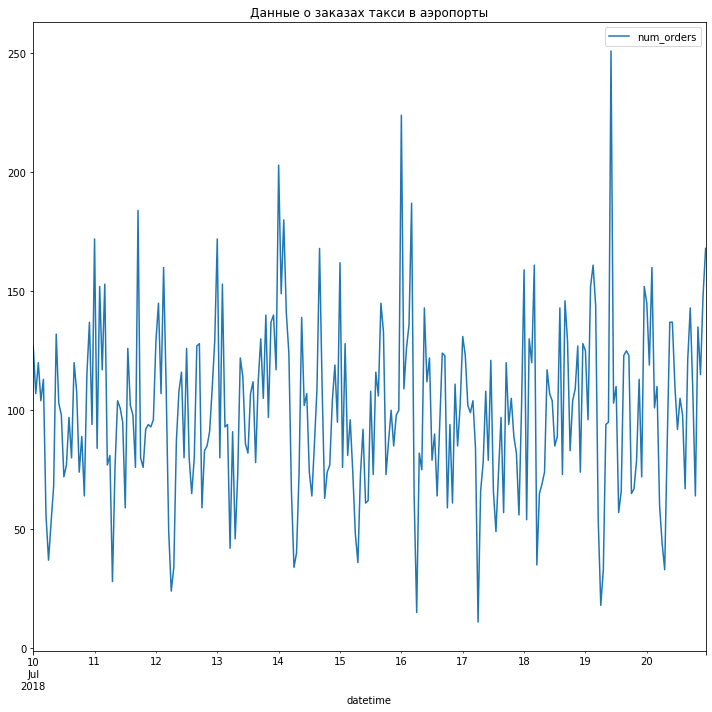

In [7]:
plt.figure(figsize=(10, 10))
ten_days.plot(ax=plt.gca())
plt.title('Данные о заказах такси в аэропорты')
plt.tight_layout()

Разложим ряд на состовляющие: тренд, сезонность и остаток.
Проанализируем визуально с помощью графиков

In [8]:
decomposed = seasonal_decompose(ten_days)

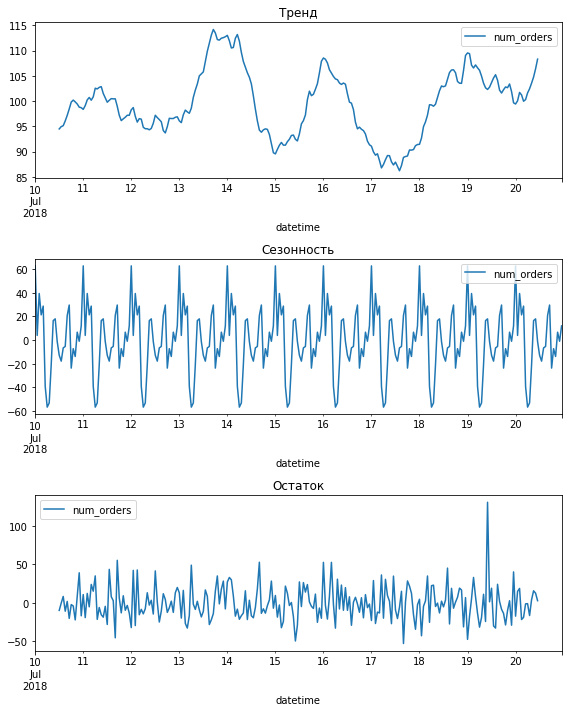

In [9]:
plt.figure(figsize=(8, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остаток')
plt.tight_layout()

**Вывод:**
- На графике трендов заметно изменение количества заказов в зависимости от дня недели. Например 13 июля в 2018 году выпало на пятницу. С 13 по 14 (с пятницы по субботу) возростает количество заказов и падает к 15 июля.
- На графике сезонностей заметно суточное изменение количетсва заказов.


### Создадим новые признаки:

In [10]:
def times_of_day(value):
    if value >=5 and value <= 11:
        return 1 #утро
    elif value >=12 and value <= 17:
        return 2 #день
    elif value >=18 and value <= 22:
        return 3 #вечер
    else:
        return 4 #ночь

In [11]:
def get_tofday(data):
    data['times_of_day'] = data.index.hour
    data['times_of_day'] = data['times_of_day'].apply(times_of_day)

In [12]:
#max_log - максимальное отставание значений
#rolling_mean_size - размер скользящего окна
def make_features(data, max_lag, rolling_mean_size):
    #календарные признаки
    data['hour'] = data.index.hour
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    get_tofday(data) #признак, указывающий на часть суток
    
    #отстающие признаки
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    #скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [13]:
make_features(taxi, 8, 7)

In [14]:
taxi.head()

,num_orders,hour,dayofweek,times_of_day,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,4,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,4,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,4,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN


In [15]:
#удалим пропуски
taxi = taxi.dropna(axis=0)

# 3. Обучение

### 3.1 Подготовка выборки

Разделим выборку на features и target

In [16]:
target = taxi.loc[:,'num_orders']
features = taxi.drop('num_orders', axis=1)

Разобъём выборку на тестовую и тренировочную части:

In [17]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            shuffle=False, 
                                                                            test_size=0.1)

In [18]:
print('Размер выборки features_train', features_train.shape)
print('Размер выборки target_train', target_train.shape)
print('Размер выборки features_test', features_test.shape)
print('Размер выборки target_test', target_test.shape)

Размер выборки features_train (3967, 12)
Размер выборки target_train (3967,)
Размер выборки features_test (441, 12)
Размер выборки target_test (441,)


### 3.2 Подбор гиперпараметеров

In [19]:
#функция для предсказаний и вычисления метрики качества
def get_rmse(model, X_test, y_test):
    y_pred = model.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    print('RMSE: {:.4f}'.format(score))
    return y_pred, score

In [20]:
my_scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [21]:
def get_best_params(features, target, model, parameters):

    #Подберём лучшие параметры модели с помощью RandomizedSearchCV
    cv = TimeSeriesSplit(n_splits=5)
    clf = RandomizedSearchCV(estimator = model,
                             param_distributions = parameters,
                             scoring=my_scorer, cv = cv,
                             random_state = 124)
    search = clf.fit(features, target)
    print('Best Params: ', search.best_params_)

### 3.3 LinearRegression

In [22]:
lr_model = LinearRegression().fit(features_train, target_train)

### 3.4 RandomForestRegressor

In [23]:
parameters ={'max_depth':np.arange(1, 11), 
             'n_estimators':np.arange(10, 50, 5)}
rand_forest = RandomForestRegressor(random_state=124)
get_best_params(features_train, target_train, rand_forest, parameters)

Best Params:  {'n_estimators': 15, 'max_depth': 10}


In [24]:
rand_forest = RandomForestRegressor(n_estimators=15, 
                                    max_depth=10, 
                                    random_state=124).fit(features_train, target_train)

### 3.5 LightGBMRegressor

In [25]:
lgbm = lgb.LGBMRegressor(max_depth=10, 
                         learning_rate=0.2, 
                         n_estimators=70, 
                         random_state=42).fit(features_train, target_train)

# 4. Тестирование

 Сравним наши модели с качеством Dummy-модели. Она будет предсказывать по принципу "в следующем часе будет так же как в этом".

In [52]:
dummy_pred = target_test.shift()
dummy_pred.iloc[0] = target_train.iloc[-1]
dummy_score = np.sqrt(mean_squared_error(target_test, dummy_pred))
print('RMSE dummy-модели', dummy_score)

RMSE dummy-модели 58.91761802963282


In [26]:
rmse = [] #метрика качества
models = ['LinearRegression', 'RandomForestRegressor', 'LightGBMRegressor']

In [27]:
models_dict = {lr_model:'LinearRegression', rand_forest:'RandomForestRegressor', lgbm:'LightGBMRegressor'}

In [28]:
prediction = []
for key in models_dict.keys():
    print('Качество модели '+models_dict[key]+' на обучающей выборке')
    name = models_dict[key]
    pred, score = get_rmse(key, features_test, target_test)
    prediction.append(pred)
    rmse.append(score)

Качество модели LinearRegression на обучающей выборке
RMSE: 53.2539
Качество модели RandomForestRegressor на обучающей выборке
RMSE: 45.8317
Качество модели LightGBMRegressor на обучающей выборке
RMSE: 43.6578


In [29]:
models_score = pd.DataFrame(data=rmse, index=models, columns=['RMSE'])

In [30]:
models_score = models_score.reset_index(drop=False)
models_score.set_axis(['models', 'RMSE'], axis='columns', inplace=True)
models_score = models_score.sort_values('RMSE')

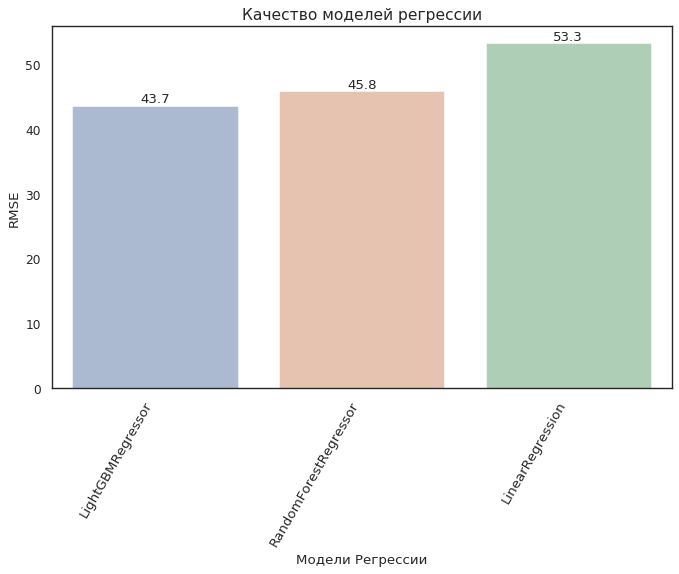

In [31]:
sns.set(style="white", palette="deep", color_codes=True)
fig, ax = plt.subplots(figsize=(10,6), dpi= 80)
plt.title('Качество моделей регрессии', fontdict={'fontsize':14})

ax=sns.barplot(x='models', y='RMSE', palette="deep", data=models_score, alpha=.5)
for i, rmse in enumerate(models_score.RMSE):
    ax.text(i, rmse+0.5, round(rmse, 1), horizontalalignment='center')
ax.set_xlabel('Модели Регрессии')
ax.set_ylabel('RMSE')
plt.xticks( rotation=60, horizontalalignment='right', fontsize=12)
plt.show()

In [42]:
models_predict = pd.DataFrame(target_test)
models_predict['LinearRegression'] = prediction[0]
models_predict['RandomForestRegressor'] = prediction[1]
models_predict['LightGBMRegressor'] = prediction[2]

In [43]:
models_predict.head()

,num_orders,LinearRegression,RandomForestRegressor,LightGBMRegressor
datetime,,,,
2018-08-13 15:00:00,175,82.378410,95.520997,113.280653
2018-08-13 16:00:00,144,124.515154,130.535315,123.294462
2018-08-13 17:00:00,152,123.094133,128.247964,141.305685
2018-08-13 18:00:00,104,133.602538,120.963016,111.999046
2018-08-13 19:00:00,91,103.674113,113.713837,106.683518


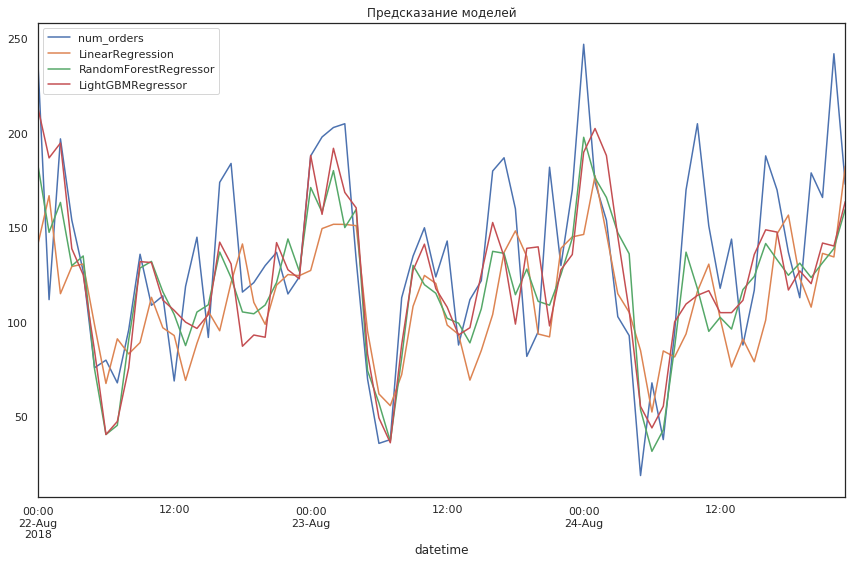

In [51]:
plt.figure(figsize=(12, 8))
models_predict['2018-08-22':'2018-08-24'].plot(ax=plt.gca())
plt.title('Предсказание моделей')
plt.tight_layout()

### Вывод:

- Наименьшее значение RMSE показывает модель `RandomForestRegressor` со значением **43.5918**
- По графику видно, что минимумы `RandomForestRegressor` предсказывает неплхо, а вот максимумы так же плохо как и другие модели. Предсказать потенциальный недостаток машин в районе аэропорта будет сложно. Необходимо искать более подходящую модель.